# Get AIrsenal's predictions for a set of fixtures

In [1]:
import numpy as np
import pandas as pd
import operator
from airsenal.framework.bpl_interface import get_fitted_team_model
from airsenal.framework.schema import session
from airsenal.framework.utils import get_fixtures_for_gameweek
import matplotlib.pyplot as plt


/Users/crangelsmith/opt/anaconda3/envs/airsenalenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
season = "2122"
max_goals = 8

In [3]:

def run_match_prediction(gw, season, max_goals, n_weeks):
    
    results_dict = {}
    
    model = get_fitted_team_model(season, gw, session)
    
    fixtures = get_fixtures_for_gameweek(gw, season, session)
    
    if n_weeks>0:
        for week in range(gw,gw+n_weeks):
            fixtures.extend(get_fixtures_for_gameweek(week, season, session))
        
    
    outcome_probs = [
    model.predict_outcome_proba(f.home_team, f.away_team) for f in fixtures
    ]
    

    
    
    most_likely_outcome = []
    for o in outcome_probs:
        if (o["home_win"] >= o["away_win"]) and (o["home_win"] >= o["draw"]):
            most_likely_outcome.append("home_win")
        elif (o["away_win"] > o["home_win"]) and (o["away_win"] >= o["draw"]):
            most_likely_outcome.append("away_win")
        else:
            most_likely_outcome.append("draw")
            
            
    goal_probs = [
    (
        model.predict_score_n_proba(
            np.arange(max_goals), f.home_team, f.away_team, home=True
        ),
        model.predict_score_n_proba(
            np.arange(max_goals), f.away_team, f.home_team, home=False
        ),
    )
    for f in fixtures
    ]
    mean_goals = [
    (
        round(np.average(np.arange(max_goals), weights=g[0]), 2),
        round(np.average(np.arange(max_goals), weights=g[1]), 2),
    )
    for g in goal_probs
    ]
    
    
    result_prob = []

    for f, o, m in zip(fixtures, most_likely_outcome, mean_goals):
        
        results_dict = {}
        if f.result:
            actual_prob = model.predict_score_proba(
                f.home_team, f.away_team, f.result.home_score, f.result.away_score
            )
            print(f.result, ", PREDICT:", o, m, f", ACTUAL: {float(actual_prob):.1%}")
            
            outcome_probs = model.predict_outcome_proba(f.home_team, f.away_team)
                        
            
            max_predicted_prob = max(outcome_probs.items(), key=operator.itemgetter(1))
            
            n_weeks_ahead = f.gameweek - gw
                            
            results_dict = {'season':f.season,'gameweek':f.gameweek,'home_team':f.home_team, 'away_team':f.away_team,
                           'home_score':f.result.home_score,'away_score':f.result.away_score, 'predicted_home_score':m[0],
                            'predicted_away_score':m[1], 'probability_result':float(actual_prob),'predicted_outcome_prob':max_predicted_prob[1].item(),
                            'predicted_outcome':max_predicted_prob[0],'n_weeks_ahead':n_weeks_ahead}

            
      
            result_prob.append(results_dict)
        
    result_prob = pd.DataFrame(result_prob)
    result_prob['diff_score_home'] = abs(result_prob['home_score'] - result_prob['predicted_home_score'])
    result_prob['diff_score_away'] = abs(result_prob['away_score'] - result_prob['predicted_away_score'])
    result_prob['diff_score_mean'] = (result_prob['diff_score_home'] + result_prob['diff_score_away'])/2
    result_prob['outcome'] = np.where(result_prob['home_score'] == result_prob['away_score'], 'draw', 'other')
    result_prob['outcome'] = np.where(result_prob['home_score'] > result_prob['away_score'], 'home_win', 'away_win')
    
    result_prob['result_correct'] = np.where(result_prob['outcome'] == result_prob['predicted_outcome'], 1, 0)

    result_prob['home_score_correct'] = np.where(result_prob['home_score'] == result_prob['predicted_home_score'], 1, 0)
    result_prob['away_score_correct'] = np.where(result_prob['away_score'] == result_prob['home_score'], 1, 0)

    
    return result_prob


    
     

In [4]:
def make_scatter_error_plot(df,column):

    # Grouping the DataFrame by 'gameweek' and calculating mean and standard deviation
    grouped = df.groupby('gameweek')[column].agg(['mean', 'std'])

    # Resetting the index to convert the grouped result back to a DataFrame
    grouped = grouped.reset_index()

    # Plotting the mean values
    plt.plot(grouped['gameweek'], grouped['mean'], marker='o')

    # Plotting filled error bars
    plt.fill_between(grouped['gameweek'], grouped['mean'] - grouped['std'], grouped['mean'] + grouped['std'], alpha=0.3)

    # Adding labels and title to the plot
    plt.xlabel('Game week')
    plt.ylabel(column)
    plt.title(column+' by Gameweek')

    # Displaying the plot
    plt.show()

In [5]:
#accuracy of 0 or more than 0

In [6]:
one_to_38_week_prediction = run_match_prediction(1,season, max_goals,38)


Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:17<00:00, 84.85it/s, 127 steps of size 4.15e-02. acc. prob=0.93]


Adding BRE to team model with covariates
2122 GW1 BRE 2 - 0 ARS , PREDICT: away_win (1.08, 1.69) , ACTUAL: 3.6%
2122 GW1 MUN 5 - 1 LEE , PREDICT: home_win (1.83, 0.99) , ACTUAL: 1.0%
2122 GW1 BUR 1 - 2 BHA , PREDICT: home_win (1.18, 0.93) , ACTUAL: 6.2%
2122 GW1 CHE 3 - 0 CRY , PREDICT: home_win (1.98, 0.85) , ACTUAL: 7.6%
2122 GW1 EVE 3 - 1 SOU , PREDICT: home_win (1.6, 1.04) , ACTUAL: 5.0%
2122 GW1 LEI 1 - 0 WOL , PREDICT: home_win (1.57, 1.07) , ACTUAL: 10.6%
2122 GW1 WAT 3 - 2 AVL , PREDICT: home_win (1.31, 1.17) , ACTUAL: 2.1%
2122 GW1 NOR 0 - 3 LIV , PREDICT: away_win (0.88, 2.26) , ACTUAL: 8.4%
2122 GW1 NEW 2 - 4 WHU , PREDICT: away_win (1.34, 1.35) , ACTUAL: 0.8%
2122 GW1 TOT 1 - 0 MCI , PREDICT: away_win (1.46, 1.56) , ACTUAL: 6.5%
2122 GW1 BRE 2 - 0 ARS , PREDICT: away_win (1.08, 1.69) , ACTUAL: 3.6%
2122 GW1 MUN 5 - 1 LEE , PREDICT: home_win (1.83, 0.99) , ACTUAL: 1.0%
2122 GW1 BUR 1 - 2 BHA , PREDICT: home_win (1.18, 0.93) , ACTUAL: 6.2%
2122 GW1 CHE 3 - 0 CRY , PREDICT: ho

2122 GW11 WHU 3 - 2 LIV , PREDICT: away_win (1.2, 1.93) , ACTUAL: 2.3%
2122 GW12 LEI 0 - 3 CHE , PREDICT: away_win (1.4, 1.44) , ACTUAL: 2.9%
2122 GW12 AVL 2 - 0 BHA , PREDICT: home_win (1.28, 0.99) , ACTUAL: 8.4%
2122 GW12 BUR 3 - 3 CRY , PREDICT: home_win (1.21, 1.04) , ACTUAL: 0.6%
2122 GW12 NEW 3 - 3 BRE , PREDICT: home_win (1.41, 1.07) , ACTUAL: 0.8%
2122 GW12 NOR 2 - 1 SOU , PREDICT: away_win (1.21, 1.37) , ACTUAL: 7.5%
2122 GW12 WAT 4 - 1 MUN , PREDICT: away_win (0.94, 1.67) , ACTUAL: 0.4%
2122 GW12 WOL 1 - 0 WHU , PREDICT: home_win (1.47, 1.17) , ACTUAL: 9.8%
2122 GW12 LIV 4 - 0 ARS , PREDICT: home_win (1.96, 1.17) , ACTUAL: 2.7%
2122 GW12 MCI 3 - 0 EVE , PREDICT: home_win (2.35, 0.86) , ACTUAL: 8.8%
2122 GW12 TOT 2 - 1 LEE , PREDICT: home_win (2.1, 0.99) , ACTUAL: 9.8%
2122 GW13 ARS 2 - 0 NEW , PREDICT: home_win (2.0, 0.89) , ACTUAL: 11.0%
2122 GW13 CRY 1 - 2 AVL , PREDICT: home_win (1.34, 1.08) , ACTUAL: 6.9%
2122 GW13 LIV 4 - 0 SOU , PREDICT: home_win (2.36, 0.85) , ACTUAL: 

2122 GW25 MUN 1 - 1 SOU , PREDICT: home_win (1.88, 0.85) , ACTUAL: 10.9%
2122 GW25 BRE 0 - 0 CRY , PREDICT: home_win (1.31, 1.16) , ACTUAL: 9.4%
2122 GW25 EVE 3 - 0 LEE , PREDICT: home_win (1.55, 1.2) , ACTUAL: 4.0%
2122 GW25 WAT 0 - 2 BHA , PREDICT: home_win (1.25, 1.06) , ACTUAL: 5.6%
2122 GW25 NOR 0 - 4 MCI , PREDICT: away_win (0.81, 2.48) , ACTUAL: 6.0%
2122 GW25 BUR 0 - 1 LIV , PREDICT: away_win (0.88, 1.84) , ACTUAL: 11.5%
2122 GW25 NEW 1 - 0 AVL , PREDICT: home_win (1.36, 1.08) , ACTUAL: 11.1%
2122 GW25 TOT 0 - 2 WOL , PREDICT: home_win (1.89, 0.88) , ACTUAL: 2.4%
2122 GW25 LEI 2 - 2 WHU , PREDICT: home_win (1.79, 1.19) , ACTUAL: 5.7%
2122 GW25 MUN 2 - 0 BHA , PREDICT: home_win (1.83, 0.71) , ACTUAL: 13.2%
2122 GW26 WHU 1 - 1 NEW , PREDICT: home_win (1.64, 1.08) , ACTUAL: 12.2%
2122 GW26 ARS 2 - 1 BRE , PREDICT: home_win (2.11, 0.88) , ACTUAL: 9.7%
2122 GW26 AVL 0 - 1 WAT , PREDICT: home_win (1.43, 1.06) , ACTUAL: 8.1%
2122 GW26 BHA 0 - 3 BUR , PREDICT: home_win (1.14, 0.96) , A

2122 GW36 BUR 1 - 3 AVL , PREDICT: home_win (1.23, 1.03) , ACTUAL: 2.3%
2122 GW36 CHE 2 - 2 WOL , PREDICT: home_win (1.73, 0.94) , ACTUAL: 4.5%
2122 GW36 CRY 1 - 0 WAT , PREDICT: home_win (1.43, 1.04) , ACTUAL: 11.4%
2122 GW36 BHA 4 - 0 MUN , PREDICT: away_win (0.87, 1.5) , ACTUAL: 0.2%
2122 GW36 LIV 1 - 1 TOT , PREDICT: home_win (1.74, 1.3) , ACTUAL: 11.3%
2122 GW36 ARS 2 - 1 LEE , PREDICT: home_win (1.94, 1.12) , ACTUAL: 9.8%
2122 GW36 LEI 1 - 2 EVE , PREDICT: home_win (1.6, 1.13) , ACTUAL: 6.7%
2122 GW36 NOR 0 - 4 WHU , PREDICT: away_win (1.2, 1.58) , ACTUAL: 1.6%
2122 GW36 MCI 5 - 0 NEW , PREDICT: home_win (2.63, 0.73) , ACTUAL: 3.8%
2122 GW36 AVL 1 - 2 LIV , PREDICT: away_win (0.96, 1.96) , ACTUAL: 9.8%
2122 GW36 LEE 0 - 3 CHE , PREDICT: away_win (1.3, 1.57) , ACTUAL: 3.7%
2122 GW36 LEI 3 - 0 NOR , PREDICT: home_win (2.1, 0.87) , ACTUAL: 8.0%
2122 GW36 WAT 0 - 0 EVE , PREDICT: away_win (1.15, 1.39) , ACTUAL: 8.7%
2122 GW36 WOL 1 - 5 MCI , PREDICT: away_win (0.99, 1.86) , ACTUAL: 1

In [7]:
full_df = []

for week in range(1,39):
    print (week)

    df = run_match_prediction(week,season, max_goals,0)
    
    full_df.append(df)
    
one_week_prediction = pd.concat(full_df)


1
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:17<00:00, 84.02it/s, 127 steps of size 4.15e-02. acc. prob=0.93]


Adding BRE to team model with covariates
2122 GW1 BRE 2 - 0 ARS , PREDICT: away_win (1.08, 1.71) , ACTUAL: 3.6%
2122 GW1 MUN 5 - 1 LEE , PREDICT: home_win (1.83, 0.99) , ACTUAL: 1.0%
2122 GW1 BUR 1 - 2 BHA , PREDICT: home_win (1.18, 0.93) , ACTUAL: 6.2%
2122 GW1 CHE 3 - 0 CRY , PREDICT: home_win (1.98, 0.85) , ACTUAL: 7.6%
2122 GW1 EVE 3 - 1 SOU , PREDICT: home_win (1.6, 1.04) , ACTUAL: 5.0%
2122 GW1 LEI 1 - 0 WOL , PREDICT: home_win (1.57, 1.07) , ACTUAL: 10.6%
2122 GW1 WAT 3 - 2 AVL , PREDICT: home_win (1.31, 1.17) , ACTUAL: 2.1%
2122 GW1 NOR 0 - 3 LIV , PREDICT: away_win (0.88, 2.26) , ACTUAL: 8.4%
2122 GW1 NEW 2 - 4 WHU , PREDICT: away_win (1.34, 1.35) , ACTUAL: 0.8%
2122 GW1 TOT 1 - 0 MCI , PREDICT: away_win (1.46, 1.56) , ACTUAL: 6.5%
2
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 81.36it/s, 127 steps of size 3.70e-02. acc. prob=0.94]


2122 GW2 LIV 2 - 0 BUR , PREDICT: home_win (2.27, 0.72) , ACTUAL: 12.9%
2122 GW2 AVL 2 - 0 NEW , PREDICT: home_win (1.33, 1.11) , ACTUAL: 7.7%
2122 GW2 CRY 0 - 0 BRE , PREDICT: home_win (1.46, 1.01) , ACTUAL: 9.2%
2122 GW2 LEE 2 - 2 EVE , PREDICT: home_win (1.49, 1.27) , ACTUAL: 5.6%
2122 GW2 MCI 5 - 0 NOR , PREDICT: home_win (3.04, 0.65) , ACTUAL: 5.7%
2122 GW2 BHA 2 - 0 WAT , PREDICT: home_win (1.31, 1.02) , ACTUAL: 8.4%
2122 GW2 SOU 1 - 1 MUN , PREDICT: away_win (1.04, 1.56) , ACTUAL: 12.6%
2122 GW2 WOL 0 - 1 TOT , PREDICT: away_win (1.06, 1.54) , ACTUAL: 10.8%
2122 GW2 ARS 0 - 2 CHE , PREDICT: home_win (1.56, 1.34) , ACTUAL: 5.0%
2122 GW2 WHU 4 - 1 LEI , PREDICT: away_win (1.46, 1.48) , ACTUAL: 1.5%
3
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 76.97it/s, 127 steps of size 3.74e-02. acc. prob=0.93]


2122 GW3 MCI 5 - 0 ARS , PREDICT: home_win (2.22, 1.06) , ACTUAL: 1.7%
2122 GW3 AVL 1 - 1 BRE , PREDICT: home_win (1.48, 1.01) , ACTUAL: 12.9%
2122 GW3 BHA 0 - 2 EVE , PREDICT: away_win (1.08, 1.24) , ACTUAL: 7.6%
2122 GW3 NEW 2 - 2 SOU , PREDICT: home_win (1.34, 1.17) , ACTUAL: 5.0%
2122 GW3 NOR 1 - 2 LEI , PREDICT: away_win (1.06, 1.74) , ACTUAL: 9.6%
2122 GW3 WHU 2 - 2 CRY , PREDICT: home_win (1.67, 1.09) , ACTUAL: 5.2%
2122 GW3 LIV 1 - 1 CHE , PREDICT: home_win (1.85, 1.18) , ACTUAL: 11.1%
2122 GW3 BUR 1 - 1 LEE , PREDICT: away_win (1.2, 1.3) , ACTUAL: 13.3%
2122 GW3 TOT 1 - 0 WAT , PREDICT: home_win (2.34, 0.76) , ACTUAL: 10.1%
2122 GW3 WOL 0 - 1 MUN , PREDICT: away_win (1.06, 1.33) , ACTUAL: 11.6%
4
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 79.52it/s, 127 steps of size 4.11e-02. acc. prob=0.92]


2122 GW4 CRY 3 - 0 TOT , PREDICT: away_win (0.94, 1.78) , ACTUAL: 0.9%
2122 GW4 ARS 1 - 0 NOR , PREDICT: home_win (2.34, 0.8) , ACTUAL: 9.6%
2122 GW4 BRE 0 - 1 BHA , PREDICT: home_win (1.18, 1.07) , ACTUAL: 10.6%
2122 GW4 LEI 0 - 1 MCI , PREDICT: away_win (1.19, 1.9) , ACTUAL: 8.2%
2122 GW4 MUN 4 - 1 NEW , PREDICT: home_win (1.91, 0.78) , ACTUAL: 3.0%
2122 GW4 SOU 0 - 0 WHU , PREDICT: home_win (1.45, 1.37) , ACTUAL: 6.6%
2122 GW4 WAT 0 - 2 WOL , PREDICT: away_win (1.11, 1.29) , ACTUAL: 7.6%
2122 GW4 CHE 3 - 0 AVL , PREDICT: home_win (2.05, 0.84) , ACTUAL: 8.0%
2122 GW4 LEE 0 - 3 LIV , PREDICT: away_win (1.21, 1.92) , ACTUAL: 5.2%
2122 GW4 EVE 3 - 1 BUR , PREDICT: home_win (1.55, 0.89) , ACTUAL: 4.8%
5
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 78.14it/s, 127 steps of size 3.19e-02. acc. prob=0.94]


2122 GW5 NEW 1 - 1 LEE , PREDICT: away_win (1.34, 1.36) , ACTUAL: 12.8%
2122 GW5 WOL 0 - 2 BRE , PREDICT: home_win (1.59, 0.83) , ACTUAL: 3.1%
2122 GW5 BUR 0 - 1 ARS , PREDICT: away_win (1.01, 1.52) , ACTUAL: 11.4%
2122 GW5 LIV 3 - 0 CRY , PREDICT: home_win (2.36, 0.79) , ACTUAL: 9.4%
2122 GW5 MCI 0 - 0 SOU , PREDICT: home_win (2.65, 0.77) , ACTUAL: 3.5%
2122 GW5 NOR 1 - 3 WAT , PREDICT: home_win (1.28, 1.22) , ACTUAL: 3.2%
2122 GW5 AVL 3 - 0 EVE , PREDICT: away_win (1.19, 1.33) , ACTUAL: 2.3%
2122 GW5 BHA 2 - 1 LEI , PREDICT: away_win (1.07, 1.42) , ACTUAL: 6.7%
2122 GW5 WHU 1 - 2 MUN , PREDICT: away_win (1.21, 1.56) , ACTUAL: 9.2%
2122 GW5 TOT 0 - 3 CHE , PREDICT: home_win (1.65, 1.18) , ACTUAL: 1.6%
6
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 79.22it/s, 127 steps of size 3.74e-02. acc. prob=0.93]


2122 GW6 CHE 0 - 1 MCI , PREDICT: away_win (1.32, 1.63) , ACTUAL: 8.0%
2122 GW6 MUN 0 - 1 AVL , PREDICT: home_win (1.96, 0.79) , ACTUAL: 4.5%
2122 GW6 EVE 2 - 0 NOR , PREDICT: home_win (1.92, 0.86) , ACTUAL: 11.5%
2122 GW6 LEE 1 - 2 WHU , PREDICT: home_win (1.65, 1.35) , ACTUAL: 7.4%
2122 GW6 LEI 2 - 2 BUR , PREDICT: home_win (1.71, 0.88) , ACTUAL: 4.2%
2122 GW6 WAT 1 - 1 NEW , PREDICT: home_win (1.31, 1.18) , ACTUAL: 13.4%
2122 GW6 BRE 3 - 3 LIV , PREDICT: away_win (0.88, 2.11) , ACTUAL: 0.9%
2122 GW6 SOU 0 - 1 WOL , PREDICT: home_win (1.22, 1.17) , ACTUAL: 10.0%
2122 GW6 ARS 3 - 1 TOT , PREDICT: away_win (1.44, 1.47) , ACTUAL: 4.0%
2122 GW6 CRY 1 - 1 BHA , PREDICT: home_win (1.27, 0.98) , ACTUAL: 13.7%
7
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 77.97it/s, 127 steps of size 3.86e-02. acc. prob=0.93]


2122 GW7 MUN 1 - 1 EVE , PREDICT: home_win (1.7, 0.93) , ACTUAL: 11.9%
2122 GW7 BUR 0 - 0 NOR , PREDICT: home_win (1.44, 0.91) , ACTUAL: 10.3%
2122 GW7 CHE 3 - 1 SOU , PREDICT: home_win (1.99, 0.89) , ACTUAL: 6.5%
2122 GW7 LEE 1 - 0 WAT , PREDICT: home_win (1.78, 1.04) , ACTUAL: 10.1%
2122 GW7 WOL 2 - 1 NEW , PREDICT: home_win (1.45, 0.92) , ACTUAL: 9.0%
2122 GW7 BHA 0 - 0 ARS , PREDICT: away_win (1.01, 1.53) , ACTUAL: 8.6%
2122 GW7 CRY 2 - 2 LEI , PREDICT: away_win (1.17, 1.47) , ACTUAL: 5.2%
2122 GW7 TOT 2 - 1 AVL , PREDICT: home_win (2.17, 0.8) , ACTUAL: 9.6%
2122 GW7 WHU 1 - 2 BRE , PREDICT: home_win (1.82, 1.02) , ACTUAL: 5.4%
2122 GW7 LIV 2 - 2 MCI , PREDICT: home_win (1.56, 1.54) , ACTUAL: 6.4%
8
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 79.77it/s, 127 steps of size 3.70e-02. acc. prob=0.93]


2122 GW8 WAT 0 - 5 LIV , PREDICT: away_win (0.94, 2.11) , ACTUAL: 1.7%
2122 GW8 AVL 2 - 3 WOL , PREDICT: away_win (1.14, 1.2) , ACTUAL: 1.8%
2122 GW8 LEI 4 - 2 MUN , PREDICT: away_win (1.29, 1.38) , ACTUAL: 0.8%
2122 GW8 MCI 2 - 0 BUR , PREDICT: home_win (2.53, 0.65) , ACTUAL: 13.2%
2122 GW8 NOR 0 - 0 BHA , PREDICT: away_win (1.12, 1.16) , ACTUAL: 11.1%
2122 GW8 SOU 1 - 0 LEE , PREDICT: home_win (1.41, 1.33) , ACTUAL: 8.5%
2122 GW8 BRE 0 - 1 CHE , PREDICT: away_win (0.97, 1.77) , ACTUAL: 10.9%
2122 GW8 EVE 0 - 1 WHU , PREDICT: home_win (1.63, 1.21) , ACTUAL: 6.5%
2122 GW8 NEW 2 - 3 TOT , PREDICT: away_win (0.99, 1.79) , ACTUAL: 2.9%
2122 GW8 ARS 2 - 2 CRY , PREDICT: home_win (1.98, 0.91) , ACTUAL: 4.5%
9
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 75.93it/s, 127 steps of size 3.93e-02. acc. prob=0.93]


2122 GW9 ARS 3 - 1 AVL , PREDICT: home_win (2.02, 0.92) , ACTUAL: 6.6%
2122 GW9 CHE 7 - 0 NOR , PREDICT: home_win (2.34, 0.72) , ACTUAL: 0.4%
2122 GW9 CRY 1 - 1 NEW , PREDICT: home_win (1.34, 1.09) , ACTUAL: 13.4%
2122 GW9 EVE 2 - 5 WAT , PREDICT: home_win (1.76, 0.93) , ACTUAL: 0.1%
2122 GW9 LEE 1 - 1 WOL , PREDICT: home_win (1.38, 1.18) , ACTUAL: 13.1%
2122 GW9 SOU 2 - 2 BUR , PREDICT: home_win (1.36, 0.98) , ACTUAL: 4.3%
2122 GW9 BHA 1 - 4 MCI , PREDICT: away_win (0.79, 2.02) , ACTUAL: 3.3%
2122 GW9 BRE 1 - 2 LEI , PREDICT: away_win (1.11, 1.61) , ACTUAL: 9.3%
2122 GW9 WHU 1 - 0 TOT , PREDICT: away_win (1.22, 1.77) , ACTUAL: 5.6%
2122 GW9 MUN 0 - 5 LIV , PREDICT: away_win (1.39, 1.43) , ACTUAL: 0.3%
10
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 79.23it/s, 127 steps of size 4.07e-02. acc. prob=0.92]


2122 GW10 LEI 0 - 2 ARS , PREDICT: home_win (1.49, 1.42) , ACTUAL: 5.5%
2122 GW10 BUR 3 - 1 BRE , PREDICT: home_win (1.3, 0.96) , ACTUAL: 3.7%
2122 GW10 LIV 2 - 2 BHA , PREDICT: home_win (2.3, 0.7) , ACTUAL: 3.2%
2122 GW10 MCI 0 - 2 CRY , PREDICT: home_win (2.64, 0.72) , ACTUAL: 0.9%
2122 GW10 NEW 0 - 3 CHE , PREDICT: away_win (1.03, 1.66) , ACTUAL: 5.2%
2122 GW10 WAT 0 - 1 SOU , PREDICT: home_win (1.29, 1.27) , ACTUAL: 9.2%
2122 GW10 TOT 0 - 3 MUN , PREDICT: home_win (1.56, 1.14) , ACTUAL: 1.7%
2122 GW10 NOR 1 - 2 LEE , PREDICT: away_win (1.13, 1.58) , ACTUAL: 9.2%
2122 GW10 AVL 1 - 4 WHU , PREDICT: away_win (1.34, 1.4) , ACTUAL: 1.4%
2122 GW10 WOL 2 - 1 EVE , PREDICT: home_win (1.31, 1.1) , ACTUAL: 8.4%
11
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 77.62it/s, 127 steps of size 4.01e-02. acc. prob=0.93]


2122 GW11 SOU 1 - 0 AVL , PREDICT: home_win (1.46, 1.1) , ACTUAL: 10.7%
2122 GW11 MUN 0 - 2 MCI , PREDICT: away_win (1.24, 1.56) , ACTUAL: 7.4%
2122 GW11 BRE 1 - 2 NOR , PREDICT: home_win (1.49, 1.02) , ACTUAL: 6.2%
2122 GW11 CHE 1 - 1 BUR , PREDICT: home_win (1.93, 0.76) , ACTUAL: 10.4%
2122 GW11 CRY 2 - 0 WOL , PREDICT: away_win (1.13, 1.19) , ACTUAL: 6.3%
2122 GW11 BHA 1 - 1 NEW , PREDICT: home_win (1.22, 1.04) , ACTUAL: 13.8%
2122 GW11 ARS 1 - 0 WAT , PREDICT: home_win (2.15, 0.87) , ACTUAL: 10.0%
2122 GW11 EVE 0 - 0 TOT , PREDICT: away_win (1.19, 1.59) , ACTUAL: 6.8%
2122 GW11 LEE 1 - 1 LEI , PREDICT: away_win (1.44, 1.47) , ACTUAL: 12.0%
2122 GW11 WHU 3 - 2 LIV , PREDICT: away_win (1.2, 1.97) , ACTUAL: 2.4%
12
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 76.30it/s, 127 steps of size 3.72e-02. acc. prob=0.93]


2122 GW12 LEI 0 - 3 CHE , PREDICT: away_win (1.36, 1.47) , ACTUAL: 3.1%
2122 GW12 AVL 2 - 0 BHA , PREDICT: home_win (1.28, 1.01) , ACTUAL: 8.2%
2122 GW12 BUR 3 - 3 CRY , PREDICT: home_win (1.21, 1.06) , ACTUAL: 0.6%
2122 GW12 NEW 3 - 3 BRE , PREDICT: home_win (1.48, 1.02) , ACTUAL: 0.8%
2122 GW12 NOR 2 - 1 SOU , PREDICT: away_win (1.14, 1.39) , ACTUAL: 7.1%
2122 GW12 WAT 4 - 1 MUN , PREDICT: away_win (0.94, 1.7) , ACTUAL: 0.4%
2122 GW12 WOL 1 - 0 WHU , PREDICT: home_win (1.45, 1.18) , ACTUAL: 9.9%
2122 GW12 LIV 4 - 0 ARS , PREDICT: home_win (1.99, 1.17) , ACTUAL: 2.8%
2122 GW12 MCI 3 - 0 EVE , PREDICT: home_win (2.37, 0.84) , ACTUAL: 8.9%
2122 GW12 TOT 2 - 1 LEE , PREDICT: home_win (2.07, 0.97) , ACTUAL: 9.8%
13
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:18<00:00, 80.00it/s, 127 steps of size 4.16e-02. acc. prob=0.93]


2122 GW13 ARS 2 - 0 NEW , PREDICT: home_win (2.01, 0.91) , ACTUAL: 10.9%
2122 GW13 CRY 1 - 2 AVL , PREDICT: home_win (1.37, 1.1) , ACTUAL: 6.9%
2122 GW13 LIV 4 - 0 SOU , PREDICT: home_win (2.38, 0.84) , ACTUAL: 5.4%
2122 GW13 NOR 0 - 0 WOL , PREDICT: away_win (0.99, 1.43) , ACTUAL: 9.7%
2122 GW13 BHA 0 - 0 LEE , PREDICT: away_win (1.18, 1.26) , ACTUAL: 9.5%
2122 GW13 BRE 1 - 0 EVE , PREDICT: away_win (1.13, 1.43) , ACTUAL: 8.1%
2122 GW13 LEI 4 - 2 WAT , PREDICT: home_win (1.93, 0.94) , ACTUAL: 1.5%
2122 GW13 MCI 2 - 1 WHU , PREDICT: home_win (2.61, 0.89) , ACTUAL: 9.0%
2122 GW13 CHE 1 - 1 MUN , PREDICT: home_win (1.49, 1.18) , ACTUAL: 12.7%
14
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 77.50it/s, 127 steps of size 4.00e-02. acc. prob=0.93]


2122 GW14 NEW 1 - 1 NOR , PREDICT: home_win (1.6, 0.96) , ACTUAL: 12.4%
2122 GW14 LEE 1 - 0 CRY , PREDICT: home_win (1.59, 1.09) , ACTUAL: 10.3%
2122 GW14 SOU 2 - 2 LEI , PREDICT: away_win (1.27, 1.48) , ACTUAL: 5.6%
2122 GW14 WAT 1 - 2 CHE , PREDICT: away_win (0.99, 1.8) , ACTUAL: 9.8%
2122 GW14 WHU 1 - 1 BHA , PREDICT: home_win (1.59, 0.96) , ACTUAL: 12.5%
2122 GW14 WOL 0 - 0 BUR , PREDICT: home_win (1.38, 0.85) , ACTUAL: 11.5%
2122 GW14 AVL 1 - 2 MCI , PREDICT: away_win (0.88, 2.19) , ACTUAL: 9.7%
2122 GW14 EVE 1 - 4 LIV , PREDICT: away_win (1.16, 1.79) , ACTUAL: 2.6%
2122 GW14 TOT 2 - 0 BRE , PREDICT: home_win (2.32, 0.76) , ACTUAL: 12.3%
2122 GW14 MUN 3 - 2 ARS , PREDICT: home_win (1.58, 1.17) , ACTUAL: 2.9%
15
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 73.40it/s, 127 steps of size 3.62e-02. acc. prob=0.94]


2122 GW15 WHU 3 - 2 CHE , PREDICT: away_win (1.26, 1.63) , ACTUAL: 2.5%
2122 GW15 NEW 1 - 0 BUR , PREDICT: home_win (1.28, 1.02) , ACTUAL: 12.1%
2122 GW15 SOU 1 - 1 BHA , PREDICT: home_win (1.35, 0.97) , ACTUAL: 13.5%
2122 GW15 WOL 0 - 1 LIV , PREDICT: away_win (1.04, 1.69) , ACTUAL: 10.5%
2122 GW15 WAT 1 - 3 MCI , PREDICT: away_win (0.85, 2.32) , ACTUAL: 7.4%
2122 GW15 LEE 2 - 2 BRE , PREDICT: home_win (1.75, 0.99) , ACTUAL: 4.7%
2122 GW15 MUN 1 - 0 CRY , PREDICT: home_win (1.9, 0.82) , ACTUAL: 11.9%
2122 GW15 TOT 3 - 0 NOR , PREDICT: home_win (2.48, 0.69) , ACTUAL: 10.7%
2122 GW15 AVL 2 - 1 LEI , PREDICT: away_win (1.21, 1.53) , ACTUAL: 7.2%
2122 GW15 EVE 2 - 1 ARS , PREDICT: away_win (1.33, 1.44) , ACTUAL: 7.9%
16
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 74.14it/s, 127 steps of size 3.88e-02. acc. prob=0.94]


2122 GW16 BRE 2 - 1 WAT , PREDICT: home_win (1.38, 1.17) , ACTUAL: 8.6%
2122 GW16 MCI 1 - 0 WOL , PREDICT: home_win (2.22, 0.76) , ACTUAL: 10.8%
2122 GW16 ARS 3 - 0 SOU , PREDICT: home_win (1.97, 0.97) , ACTUAL: 6.7%
2122 GW16 CHE 3 - 2 LEE , PREDICT: home_win (1.98, 0.99) , ACTUAL: 3.2%
2122 GW16 LIV 1 - 0 AVL , PREDICT: home_win (2.48, 0.8) , ACTUAL: 8.9%
2122 GW16 NOR 0 - 1 MUN , PREDICT: away_win (0.84, 1.85) , ACTUAL: 12.0%
2122 GW16 BUR 0 - 0 WHU , PREDICT: away_win (1.21, 1.31) , ACTUAL: 8.8%
2122 GW16 LEI 4 - 0 NEW , PREDICT: home_win (1.83, 0.97) , ACTUAL: 2.8%
2122 GW16 CRY 3 - 1 EVE , PREDICT: away_win (1.2, 1.28) , ACTUAL: 3.1%
17
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 73.81it/s, 127 steps of size 3.82e-02. acc. prob=0.93]


2122 GW17 NOR 0 - 2 AVL , PREDICT: away_win (1.16, 1.3) , ACTUAL: 7.2%
2122 GW17 MCI 7 - 0 LEE , PREDICT: home_win (2.58, 0.85) , ACTUAL: 0.5%
2122 GW17 BHA 0 - 1 WOL , PREDICT: away_win (1.0, 1.1) , ACTUAL: 12.8%
2122 GW17 CRY 2 - 2 SOU , PREDICT: home_win (1.34, 1.15) , ACTUAL: 4.9%
2122 GW17 ARS 2 - 0 WHU , PREDICT: home_win (1.97, 1.14) , ACTUAL: 8.6%
2122 GW17 CHE 1 - 1 EVE , PREDICT: home_win (1.85, 0.97) , ACTUAL: 11.2%
2122 GW17 LIV 3 - 1 NEW , PREDICT: home_win (2.47, 0.78) , ACTUAL: 7.6%
18
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 75.22it/s, 127 steps of size 3.73e-02. acc. prob=0.93]


2122 GW18 LEE 1 - 4 ARS , PREDICT: away_win (1.33, 1.6) , ACTUAL: 1.9%
2122 GW18 NEW 0 - 4 MCI , PREDICT: away_win (0.87, 2.19) , ACTUAL: 4.5%
2122 GW18 WOL 0 - 0 CHE , PREDICT: away_win (1.07, 1.38) , ACTUAL: 9.4%
2122 GW18 TOT 2 - 2 LIV , PREDICT: home_win (1.53, 1.46) , ACTUAL: 6.2%
19
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 74.03it/s, 127 steps of size 3.17e-02. acc. prob=0.94]


2122 GW19 MCI 6 - 3 LEI , PREDICT: home_win (2.39, 0.96) , ACTUAL: 0.1%
2122 GW19 NOR 0 - 5 ARS , PREDICT: away_win (0.93, 1.91) , ACTUAL: 1.3%
2122 GW19 TOT 3 - 0 CRY , PREDICT: home_win (2.11, 0.82) , ACTUAL: 8.4%
2122 GW19 WHU 2 - 3 SOU , PREDICT: home_win (1.67, 1.15) , ACTUAL: 2.1%
2122 GW19 AVL 1 - 3 CHE , PREDICT: away_win (1.03, 1.68) , ACTUAL: 5.4%
2122 GW19 BHA 2 - 0 BRE , PREDICT: home_win (1.31, 1.0) , ACTUAL: 8.5%
2122 GW19 NEW 1 - 1 MUN , PREDICT: away_win (0.98, 1.6) , ACTUAL: 12.5%
20
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 76.21it/s, 127 steps of size 3.58e-02. acc. prob=0.93]


2122 GW20 CRY 3 - 0 NOR , PREDICT: home_win (1.61, 0.91) , ACTUAL: 5.7%
2122 GW20 SOU 1 - 1 TOT , PREDICT: away_win (1.04, 1.75) , ACTUAL: 11.7%
2122 GW20 WAT 1 - 4 WHU , PREDICT: away_win (1.31, 1.5) , ACTUAL: 1.7%
2122 GW20 LEI 1 - 0 LIV , PREDICT: away_win (1.31, 1.8) , ACTUAL: 5.3%
2122 GW20 CHE 1 - 1 BHA , PREDICT: home_win (1.92, 0.73) , ACTUAL: 10.4%
2122 GW20 BRE 0 - 1 MCI , PREDICT: away_win (0.82, 2.39) , ACTUAL: 9.2%
2122 GW20 MUN 3 - 1 BUR , PREDICT: home_win (1.8, 0.73) , ACTUAL: 5.6%
21
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 74.02it/s, 127 steps of size 3.56e-02. acc. prob=0.93]


2122 GW21 ARS 1 - 2 MCI , PREDICT: away_win (1.29, 1.79) , ACTUAL: 9.4%
2122 GW21 WAT 0 - 1 TOT , PREDICT: away_win (0.96, 1.92) , ACTUAL: 10.3%
2122 GW21 CRY 2 - 3 WHU , PREDICT: away_win (1.34, 1.37) , ACTUAL: 2.6%
2122 GW21 BRE 2 - 1 AVL , PREDICT: home_win (1.28, 1.21) , ACTUAL: 8.1%
2122 GW21 EVE 2 - 3 BHA , PREDICT: home_win (1.51, 0.88) , ACTUAL: 1.2%
2122 GW21 LEE 3 - 1 BUR , PREDICT: home_win (1.52, 1.01) , ACTUAL: 4.7%
2122 GW21 CHE 2 - 2 LIV , PREDICT: away_win (1.46, 1.51) , ACTUAL: 6.2%
2122 GW21 MUN 0 - 1 WOL , PREDICT: home_win (1.57, 0.84) , ACTUAL: 6.9%
2122 GW21 SOU 4 - 1 BRE , PREDICT: home_win (1.56, 1.02) , ACTUAL: 1.9%
2122 GW21 WHU 2 - 0 NOR , PREDICT: home_win (2.03, 0.9) , ACTUAL: 11.0%
22
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 72.78it/s, 127 steps of size 4.31e-02. acc. prob=0.90]


2122 GW22 BHA 1 - 1 CRY , PREDICT: home_win (1.19, 1.06) , ACTUAL: 13.9%
2122 GW22 MCI 1 - 0 CHE , PREDICT: home_win (2.04, 1.06) , ACTUAL: 8.7%
2122 GW22 NEW 1 - 1 WAT , PREDICT: home_win (1.47, 1.09) , ACTUAL: 13.0%
2122 GW22 NOR 2 - 1 EVE , PREDICT: away_win (1.0, 1.56) , ACTUAL: 6.0%
2122 GW22 WOL 3 - 1 SOU , PREDICT: home_win (1.39, 0.96) , ACTUAL: 4.1%
2122 GW22 AVL 2 - 2 MUN , PREDICT: away_win (0.98, 1.6) , ACTUAL: 4.6%
2122 GW22 LIV 3 - 0 BRE , PREDICT: home_win (2.68, 0.74) , ACTUAL: 10.5%
2122 GW22 WHU 2 - 3 LEE , PREDICT: home_win (1.72, 1.32) , ACTUAL: 2.7%
2122 GW22 BHA 1 - 1 CHE , PREDICT: away_win (0.9, 1.56) , ACTUAL: 12.5%
2122 GW22 LEI 2 - 3 TOT , PREDICT: away_win (1.33, 1.57) , ACTUAL: 3.1%
2122 GW22 BRE 1 - 3 MUN , PREDICT: away_win (0.92, 1.73) , ACTUAL: 5.5%
23
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 75.46it/s, 127 steps of size 3.46e-02. acc. prob=0.93]


2122 GW23 WAT 0 - 3 NOR , PREDICT: home_win (1.58, 0.99) , ACTUAL: 1.3%
2122 GW23 EVE 0 - 1 AVL , PREDICT: home_win (1.65, 1.01) , ACTUAL: 6.5%
2122 GW23 BRE 1 - 2 WOL , PREDICT: away_win (1.03, 1.3) , ACTUAL: 8.3%
2122 GW23 LEE 0 - 1 NEW , PREDICT: home_win (1.68, 1.09) , ACTUAL: 6.3%
2122 GW23 MUN 1 - 0 WHU , PREDICT: home_win (1.9, 1.01) , ACTUAL: 9.8%
2122 GW23 SOU 1 - 1 MCI , PREDICT: away_win (0.92, 2.16) , ACTUAL: 9.5%
2122 GW23 ARS 0 - 0 BUR , PREDICT: home_win (1.91, 0.83) , ACTUAL: 7.0%
2122 GW23 CRY 1 - 3 LIV , PREDICT: away_win (0.97, 1.98) , ACTUAL: 6.6%
2122 GW23 LEI 1 - 1 BHA , PREDICT: home_win (1.72, 0.88) , ACTUAL: 11.8%
2122 GW23 CHE 2 - 0 TOT , PREDICT: home_win (1.48, 1.32) , ACTUAL: 6.7%
2122 GW23 BUR 0 - 0 WAT , PREDICT: home_win (1.33, 1.01) , ACTUAL: 10.3%
24
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 76.48it/s, 127 steps of size 4.51e-02. acc. prob=0.90]


2122 GW24 NEW 3 - 1 EVE , PREDICT: away_win (1.22, 1.31) , ACTUAL: 3.2%
2122 GW24 WHU 1 - 0 WAT , PREDICT: home_win (1.85, 1.05) , ACTUAL: 9.6%
2122 GW24 BUR 1 - 1 MUN , PREDICT: away_win (0.88, 1.47) , ACTUAL: 12.9%
2122 GW24 MCI 2 - 0 BRE , PREDICT: home_win (2.97, 0.65) , ACTUAL: 11.5%
2122 GW24 NOR 1 - 1 CRY , PREDICT: away_win (1.13, 1.35) , ACTUAL: 13.3%
2122 GW24 TOT 2 - 3 SOU , PREDICT: home_win (2.11, 0.86) , ACTUAL: 1.2%
2122 GW24 AVL 3 - 3 LEE , PREDICT: home_win (1.39, 1.35) , ACTUAL: 1.2%
2122 GW24 LIV 2 - 0 LEI , PREDICT: home_win (2.19, 1.07) , ACTUAL: 9.1%
2122 GW24 WOL 0 - 1 ARS , PREDICT: away_win (1.17, 1.32) , ACTUAL: 10.3%
25
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 73.63it/s, 127 steps of size 3.84e-02. acc. prob=0.93]


2122 GW25 MUN 1 - 1 SOU , PREDICT: home_win (1.89, 0.86) , ACTUAL: 10.9%
2122 GW25 BRE 0 - 0 CRY , PREDICT: away_win (1.24, 1.26) , ACTUAL: 9.0%
2122 GW25 EVE 3 - 0 LEE , PREDICT: home_win (1.64, 1.23) , ACTUAL: 4.2%
2122 GW25 WAT 0 - 2 BHA , PREDICT: home_win (1.21, 1.07) , ACTUAL: 5.9%
2122 GW25 NOR 0 - 4 MCI , PREDICT: away_win (0.72, 2.56) , ACTUAL: 6.8%
2122 GW25 BUR 0 - 1 LIV , PREDICT: away_win (0.86, 1.88) , ACTUAL: 11.5%
2122 GW25 NEW 1 - 0 AVL , PREDICT: home_win (1.38, 1.14) , ACTUAL: 10.5%
2122 GW25 TOT 0 - 2 WOL , PREDICT: home_win (1.73, 0.85) , ACTUAL: 2.8%
2122 GW25 LEI 2 - 2 WHU , PREDICT: home_win (1.81, 1.24) , ACTUAL: 5.9%
2122 GW25 MUN 2 - 0 BHA , PREDICT: home_win (1.78, 0.72) , ACTUAL: 13.0%
26
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 72.77it/s, 127 steps of size 3.57e-02. acc. prob=0.93]


2122 GW26 WHU 1 - 1 NEW , PREDICT: home_win (1.71, 1.08) , ACTUAL: 11.8%
2122 GW26 ARS 2 - 1 BRE , PREDICT: home_win (2.22, 0.82) , ACTUAL: 9.5%
2122 GW26 AVL 0 - 1 WAT , PREDICT: home_win (1.5, 1.08) , ACTUAL: 7.6%
2122 GW26 BHA 0 - 3 BUR , PREDICT: home_win (1.13, 0.93) , ACTUAL: 1.7%
2122 GW26 CRY 0 - 1 CHE , PREDICT: away_win (1.01, 1.65) , ACTUAL: 10.9%
2122 GW26 LIV 3 - 1 NOR , PREDICT: home_win (2.89, 0.65) , ACTUAL: 7.5%
2122 GW26 SOU 2 - 0 EVE , PREDICT: home_win (1.32, 1.28) , ACTUAL: 6.5%
2122 GW26 MCI 2 - 3 TOT , PREDICT: home_win (1.98, 1.11) , ACTUAL: 2.0%
2122 GW26 LEE 2 - 4 MUN , PREDICT: away_win (1.18, 1.6) , ACTUAL: 1.2%
2122 GW26 WOL 2 - 1 LEI , PREDICT: home_win (1.28, 1.21) , ACTUAL: 8.2%
2122 GW26 BUR 1 - 0 TOT , PREDICT: away_win (0.89, 1.64) , ACTUAL: 6.5%
2122 GW26 WAT 1 - 4 CRY , PREDICT: home_win (1.28, 1.23) , ACTUAL: 1.0%
2122 GW26 LIV 6 - 0 LEE , PREDICT: home_win (2.49, 0.94) , ACTUAL: 1.1%
2122 GW26 ARS 2 - 1 WOL , PREDICT: home_win (1.61, 0.96) , ACTUA

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 75.54it/s, 127 steps of size 3.60e-02. acc. prob=0.92]


2122 GW27 SOU 2 - 0 NOR , PREDICT: home_win (1.75, 0.92) , ACTUAL: 10.6%
2122 GW27 LEE 0 - 4 TOT , PREDICT: away_win (1.2, 1.85) , ACTUAL: 2.4%
2122 GW27 BRE 0 - 2 NEW , PREDICT: home_win (1.24, 1.21) , ACTUAL: 6.3%
2122 GW27 CRY 1 - 1 BUR , PREDICT: home_win (1.26, 0.99) , ACTUAL: 13.7%
2122 GW27 MUN 0 - 0 WAT , PREDICT: home_win (2.08, 0.76) , ACTUAL: 6.3%
2122 GW27 BHA 0 - 2 AVL , PREDICT: home_win (1.23, 1.05) , ACTUAL: 5.6%
2122 GW27 EVE 0 - 1 MCI , PREDICT: away_win (1.02, 1.98) , ACTUAL: 9.4%
2122 GW27 WHU 1 - 0 WOL , PREDICT: home_win (1.36, 1.17) , ACTUAL: 10.2%
2122 GW27 BUR 0 - 2 LEI , PREDICT: away_win (1.1, 1.4) , ACTUAL: 8.1%
28
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 73.43it/s, 127 steps of size 3.70e-02. acc. prob=0.93]


2122 GW28 LEI 1 - 0 LEE , PREDICT: home_win (1.95, 1.2) , ACTUAL: 7.9%
2122 GW28 AVL 4 - 0 SOU , PREDICT: home_win (1.35, 1.22) , ACTUAL: 1.1%
2122 GW28 BUR 0 - 4 CHE , PREDICT: away_win (0.9, 1.55) , ACTUAL: 2.1%
2122 GW28 NEW 2 - 1 BHA , PREDICT: home_win (1.27, 0.99) , ACTUAL: 8.2%
2122 GW28 NOR 1 - 3 BRE , PREDICT: home_win (1.25, 1.2) , ACTUAL: 3.1%
2122 GW28 WOL 0 - 2 CRY , PREDICT: home_win (1.41, 0.91) , ACTUAL: 4.1%
2122 GW28 LIV 1 - 0 WHU , PREDICT: home_win (2.42, 0.98) , ACTUAL: 7.6%
2122 GW28 WAT 2 - 3 ARS , PREDICT: away_win (1.06, 1.77) , ACTUAL: 3.0%
2122 GW28 MCI 4 - 1 MUN , PREDICT: home_win (1.95, 0.99) , ACTUAL: 3.2%
2122 GW28 TOT 5 - 0 EVE , PREDICT: home_win (1.94, 0.95) , ACTUAL: 1.3%
2122 GW28 NOR 1 - 3 CHE , PREDICT: away_win (0.84, 2.0) , ACTUAL: 6.5%
2122 GW28 SOU 1 - 2 NEW , PREDICT: home_win (1.46, 1.08) , ACTUAL: 6.7%
2122 GW28 WOL 4 - 0 WAT , PREDICT: home_win (1.55, 0.84) , ACTUAL: 2.2%
2122 GW28 LEE 0 - 3 AVL , PREDICT: home_win (1.64, 1.2) , ACTUAL: 1.

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 72.59it/s, 127 steps of size 3.53e-02. acc. prob=0.93]


2122 GW29 BHA 0 - 2 LIV , PREDICT: away_win (0.84, 1.89) , ACTUAL: 11.6%
2122 GW29 BRE 2 - 0 BUR , PREDICT: home_win (1.15, 1.12) , ACTUAL: 6.9%
2122 GW29 MUN 3 - 2 TOT , PREDICT: home_win (1.39, 1.29) , ACTUAL: 2.6%
2122 GW29 CHE 1 - 0 NEW , PREDICT: home_win (2.05, 0.82) , ACTUAL: 11.2%
2122 GW29 EVE 0 - 1 WOL , PREDICT: home_win (1.28, 1.08) , ACTUAL: 9.6%
2122 GW29 LEE 2 - 1 NOR , PREDICT: home_win (1.92, 0.99) , ACTUAL: 9.8%
2122 GW29 SOU 1 - 2 WAT , PREDICT: home_win (1.59, 1.04) , ACTUAL: 6.2%
2122 GW29 WHU 2 - 1 AVL , PREDICT: home_win (1.7, 1.13) , ACTUAL: 9.6%
2122 GW29 ARS 2 - 0 LEI , PREDICT: home_win (1.8, 1.24) , ACTUAL: 7.7%
2122 GW29 CRY 0 - 0 MCI , PREDICT: away_win (0.86, 2.14) , ACTUAL: 5.4%
2122 GW29 BHA 0 - 2 TOT , PREDICT: away_win (0.88, 1.67) , ACTUAL: 10.9%
2122 GW29 ARS 0 - 2 LIV , PREDICT: away_win (1.41, 1.66) , ACTUAL: 6.4%
2122 GW29 EVE 1 - 0 NEW , PREDICT: home_win (1.6, 1.01) , ACTUAL: 11.2%
30
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:21<00:00, 69.49it/s, 127 steps of size 4.03e-02. acc. prob=0.92]


2122 GW30 WOL 2 - 3 LEE , PREDICT: home_win (1.53, 1.04) , ACTUAL: 1.7%
2122 GW30 AVL 0 - 1 ARS , PREDICT: away_win (1.14, 1.65) , ACTUAL: 9.6%
2122 GW30 LEI 2 - 1 BRE , PREDICT: home_win (2.01, 0.91) , ACTUAL: 9.8%
2122 GW30 TOT 3 - 1 WHU , PREDICT: home_win (2.12, 1.02) , ACTUAL: 7.0%
31
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 73.37it/s, 127 steps of size 4.06e-02. acc. prob=0.91]


2122 GW31 LIV 2 - 0 WAT , PREDICT: home_win (2.66, 0.73) , ACTUAL: 11.8%
2122 GW31 BHA 0 - 0 NOR , PREDICT: home_win (1.44, 0.87) , ACTUAL: 10.6%
2122 GW31 BUR 0 - 2 MCI , PREDICT: away_win (0.76, 2.03) , ACTUAL: 12.7%
2122 GW31 CHE 1 - 4 BRE , PREDICT: home_win (2.25, 0.76) , ACTUAL: 0.2%
2122 GW31 LEE 1 - 1 SOU , PREDICT: home_win (1.59, 1.27) , ACTUAL: 12.0%
2122 GW31 WOL 2 - 1 AVL , PREDICT: home_win (1.45, 0.91) , ACTUAL: 8.9%
2122 GW31 MUN 1 - 1 LEI , PREDICT: home_win (1.71, 1.1) , ACTUAL: 11.8%
2122 GW31 WHU 2 - 1 EVE , PREDICT: home_win (1.54, 1.26) , ACTUAL: 9.0%
2122 GW31 TOT 5 - 1 NEW , PREDICT: home_win (2.15, 0.8) , ACTUAL: 1.6%
2122 GW31 CRY 3 - 0 ARS , PREDICT: away_win (1.1, 1.6) , ACTUAL: 1.5%
2122 GW31 BUR 3 - 2 EVE , PREDICT: away_win (1.1, 1.2) , ACTUAL: 1.6%
32
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 71.75it/s, 127 steps of size 3.60e-02. acc. prob=0.93]


2122 GW32 NEW 1 - 0 WOL , PREDICT: away_win (1.09, 1.19) , ACTUAL: 10.5%
2122 GW32 EVE 1 - 0 MUN , PREDICT: away_win (1.16, 1.44) , ACTUAL: 8.0%
2122 GW32 ARS 1 - 2 BHA , PREDICT: home_win (1.88, 0.8) , ACTUAL: 4.1%
2122 GW32 SOU 0 - 6 CHE , PREDICT: away_win (1.08, 1.66) , ACTUAL: 0.2%
2122 GW32 WAT 0 - 3 LEE , PREDICT: away_win (1.38, 1.44) , ACTUAL: 3.0%
2122 GW32 AVL 0 - 4 TOT , PREDICT: away_win (1.01, 1.81) , ACTUAL: 2.7%
2122 GW32 BRE 2 - 0 WHU , PREDICT: away_win (1.27, 1.52) , ACTUAL: 4.9%
2122 GW32 LEI 2 - 1 CRY , PREDICT: home_win (1.78, 1.02) , ACTUAL: 9.8%
2122 GW32 NOR 2 - 0 BUR , PREDICT: away_win (1.06, 1.21) , ACTUAL: 5.8%
2122 GW32 MCI 2 - 2 LIV , PREDICT: home_win (1.87, 1.27) , ACTUAL: 6.0%
33
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 72.13it/s, 127 steps of size 3.32e-02. acc. prob=0.93]


2122 GW33 TOT 0 - 1 BHA , PREDICT: home_win (2.04, 0.71) , ACTUAL: 4.1%
2122 GW33 MUN 3 - 2 NOR , PREDICT: home_win (2.28, 0.67) , ACTUAL: 2.3%
2122 GW33 SOU 1 - 0 ARS , PREDICT: away_win (1.18, 1.63) , ACTUAL: 6.6%
2122 GW33 WAT 1 - 2 BRE , PREDICT: home_win (1.39, 1.18) , ACTUAL: 7.3%
2122 GW33 NEW 2 - 1 LEI , PREDICT: away_win (1.2, 1.52) , ACTUAL: 7.2%
2122 GW33 WHU 1 - 1 BUR , PREDICT: home_win (1.58, 0.99) , ACTUAL: 12.4%
2122 GW33 LIV 4 - 0 MUN , PREDICT: home_win (1.78, 1.09) , ACTUAL: 2.4%
2122 GW33 CHE 2 - 4 ARS , PREDICT: home_win (1.68, 1.21) , ACTUAL: 0.7%
2122 GW33 EVE 1 - 1 LEI , PREDICT: home_win (1.42, 1.38) , ACTUAL: 12.4%
2122 GW33 NEW 1 - 0 CRY , PREDICT: home_win (1.32, 1.14) , ACTUAL: 10.7%
2122 GW33 MCI 3 - 0 BHA , PREDICT: home_win (2.51, 0.61) , ACTUAL: 11.6%
2122 GW33 BUR 2 - 0 SOU , PREDICT: home_win (1.21, 1.12) , ACTUAL: 7.1%
34
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:20<00:00, 71.62it/s, 127 steps of size 3.94e-02. acc. prob=0.92]


2122 GW34 ARS 3 - 1 MUN , PREDICT: home_win (1.47, 1.29) , ACTUAL: 4.3%
2122 GW34 LEI 0 - 0 AVL , PREDICT: home_win (1.85, 1.01) , ACTUAL: 6.2%
2122 GW34 MCI 5 - 1 WAT , PREDICT: home_win (2.91, 0.65) , ACTUAL: 3.4%
2122 GW34 NOR 0 - 3 NEW , PREDICT: away_win (1.14, 1.33) , ACTUAL: 3.3%
2122 GW34 BRE 0 - 0 TOT , PREDICT: away_win (0.96, 1.94) , ACTUAL: 6.0%
2122 GW34 BHA 2 - 2 SOU , PREDICT: home_win (1.18, 1.1) , ACTUAL: 4.3%
2122 GW34 BUR 1 - 0 WOL , PREDICT: away_win (0.97, 1.1) , ACTUAL: 11.6%
2122 GW34 CHE 1 - 0 WHU , PREDICT: home_win (2.03, 1.04) , ACTUAL: 9.0%
2122 GW34 LIV 2 - 0 EVE , PREDICT: home_win (2.25, 0.88) , ACTUAL: 11.0%
2122 GW34 CRY 0 - 0 LEE , PREDICT: home_win (1.45, 1.3) , ACTUAL: 7.0%
2122 GW34 MUN 1 - 1 CHE , PREDICT: home_win (1.43, 1.24) , ACTUAL: 12.8%
35
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:21<00:00, 69.04it/s, 127 steps of size 3.44e-02. acc. prob=0.93]


2122 GW35 NEW 0 - 1 LIV , PREDICT: away_win (0.94, 2.02) , ACTUAL: 10.1%
2122 GW35 AVL 2 - 0 NOR , PREDICT: home_win (1.67, 0.94) , ACTUAL: 10.2%
2122 GW35 SOU 1 - 2 CRY , PREDICT: home_win (1.41, 1.13) , ACTUAL: 7.1%
2122 GW35 WAT 1 - 2 BUR , PREDICT: home_win (1.2, 1.1) , ACTUAL: 7.2%
2122 GW35 WOL 0 - 3 BHA , PREDICT: home_win (1.33, 0.79) , ACTUAL: 1.0%
2122 GW35 LEE 0 - 4 MCI , PREDICT: away_win (1.01, 2.29) , ACTUAL: 4.3%
2122 GW35 EVE 1 - 0 CHE , PREDICT: away_win (1.18, 1.54) , ACTUAL: 7.3%
2122 GW35 TOT 3 - 1 LEI , PREDICT: home_win (1.93, 1.09) , ACTUAL: 6.4%
2122 GW35 WHU 1 - 2 ARS , PREDICT: away_win (1.38, 1.61) , ACTUAL: 9.0%
2122 GW35 MUN 3 - 0 BRE , PREDICT: home_win (2.03, 0.79) , ACTUAL: 8.3%
36
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:21<00:00, 69.13it/s, 127 steps of size 3.72e-02. acc. prob=0.91]


2122 GW36 BRE 3 - 0 SOU , PREDICT: home_win (1.3, 1.28) , ACTUAL: 2.8%
2122 GW36 BUR 1 - 3 AVL , PREDICT: home_win (1.22, 1.05) , ACTUAL: 2.5%
2122 GW36 CHE 2 - 2 WOL , PREDICT: home_win (1.66, 0.87) , ACTUAL: 4.1%
2122 GW36 CRY 1 - 0 WAT , PREDICT: home_win (1.5, 1.02) , ACTUAL: 11.5%
2122 GW36 BHA 4 - 0 MUN , PREDICT: away_win (0.88, 1.46) , ACTUAL: 0.2%
2122 GW36 LIV 1 - 1 TOT , PREDICT: home_win (1.8, 1.23) , ACTUAL: 11.1%
2122 GW36 ARS 2 - 1 LEE , PREDICT: home_win (2.13, 1.08) , ACTUAL: 9.8%
2122 GW36 LEI 1 - 2 EVE , PREDICT: home_win (1.64, 1.14) , ACTUAL: 6.6%
2122 GW36 NOR 0 - 4 WHU , PREDICT: away_win (1.11, 1.68) , ACTUAL: 2.1%
2122 GW36 MCI 5 - 0 NEW , PREDICT: home_win (2.67, 0.69) , ACTUAL: 4.1%
2122 GW36 AVL 1 - 2 LIV , PREDICT: away_win (0.94, 2.04) , ACTUAL: 9.8%
2122 GW36 LEE 0 - 3 CHE , PREDICT: away_win (1.19, 1.78) , ACTUAL: 4.9%
2122 GW36 LEI 3 - 0 NOR , PREDICT: home_win (2.19, 0.83) , ACTUAL: 8.6%
2122 GW36 WAT 0 - 0 EVE , PREDICT: away_win (1.17, 1.41) , ACTUAL

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:22<00:00, 66.09it/s, 127 steps of size 3.38e-02. acc. prob=0.94]


2122 GW37 TOT 1 - 0 BUR , PREDICT: home_win (2.04, 0.73) , ACTUAL: 12.4%
2122 GW37 AVL 1 - 1 CRY , PREDICT: home_win (1.34, 1.14) , ACTUAL: 13.3%
2122 GW37 LEE 1 - 1 BHA , PREDICT: home_win (1.47, 1.06) , ACTUAL: 12.9%
2122 GW37 WAT 1 - 5 LEI , PREDICT: away_win (1.14, 1.65) , ACTUAL: 0.7%
2122 GW37 WHU 2 - 2 MCI , PREDICT: away_win (1.05, 2.18) , ACTUAL: 5.2%
2122 GW37 WOL 1 - 1 NOR , PREDICT: home_win (1.75, 0.75) , ACTUAL: 11.2%
2122 GW37 EVE 2 - 3 BRE , PREDICT: home_win (1.68, 0.98) , ACTUAL: 1.5%
2122 GW37 NEW 2 - 0 ARS , PREDICT: away_win (1.11, 1.63) , ACTUAL: 4.0%
2122 GW37 SOU 1 - 2 LIV , PREDICT: away_win (0.99, 2.03) , ACTUAL: 9.9%
2122 GW37 EVE 3 - 2 CRY , PREDICT: home_win (1.53, 1.03) , ACTUAL: 2.4%
2122 GW37 AVL 1 - 1 BUR , PREDICT: home_win (1.3, 1.01) , ACTUAL: 13.5%
2122 GW37 CHE 1 - 1 LEI , PREDICT: home_win (1.83, 1.12) , ACTUAL: 11.1%
38
Fitting team model...


sample: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:22<00:00, 66.71it/s, 127 steps of size 3.66e-02. acc. prob=0.92]


2122 GW38 ARS 5 - 1 EVE , PREDICT: home_win (1.82, 1.05) , ACTUAL: 1.0%
2122 GW38 BRE 1 - 2 LEE , PREDICT: home_win (1.43, 1.39) , ACTUAL: 8.1%
2122 GW38 BHA 3 - 1 WHU , PREDICT: away_win (1.19, 1.29) , ACTUAL: 3.0%
2122 GW38 BUR 1 - 2 NEW , PREDICT: home_win (1.2, 1.03) , ACTUAL: 6.8%
2122 GW38 CHE 2 - 1 WAT , PREDICT: home_win (2.26, 0.78) , ACTUAL: 9.4%
2122 GW38 CRY 1 - 0 MUN , PREDICT: away_win (1.0, 1.52) , ACTUAL: 7.4%
2122 GW38 LEI 4 - 1 SOU , PREDICT: home_win (1.83, 1.05) , ACTUAL: 2.8%
2122 GW38 LIV 3 - 1 WOL , PREDICT: home_win (2.02, 0.81) , ACTUAL: 6.5%
2122 GW38 MCI 3 - 2 AVL , PREDICT: home_win (2.73, 0.71) , ACTUAL: 2.7%
2122 GW38 NOR 0 - 5 TOT , PREDICT: away_win (0.8, 2.2) , ACTUAL: 2.2%


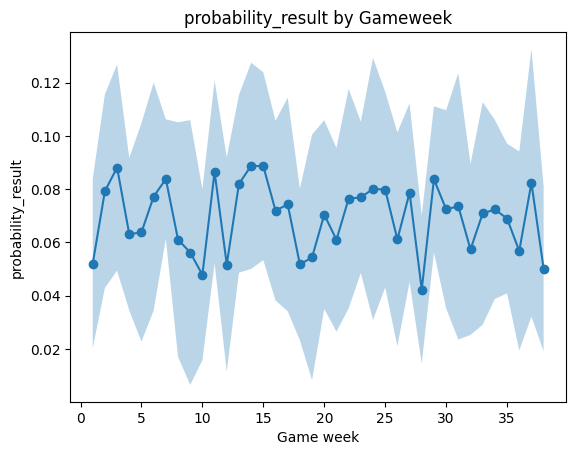

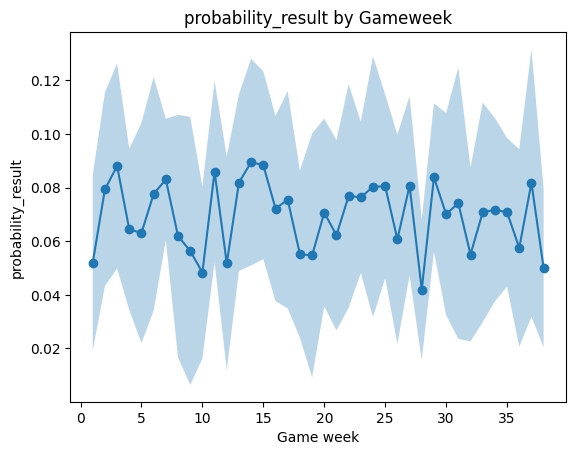

In [8]:
make_scatter_error_plot(one_to_38_week_prediction,'probability_result')
make_scatter_error_plot(one_week_prediction,'probability_result')

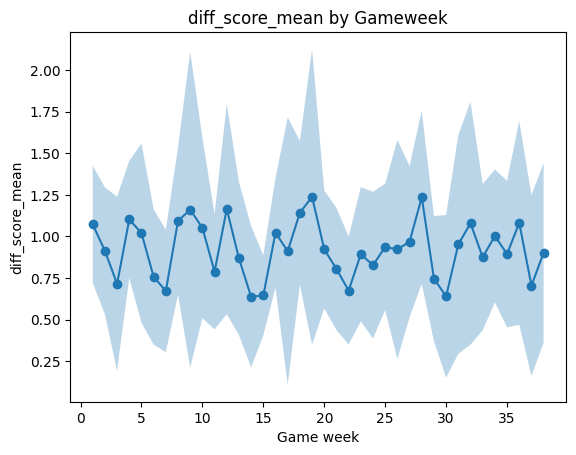

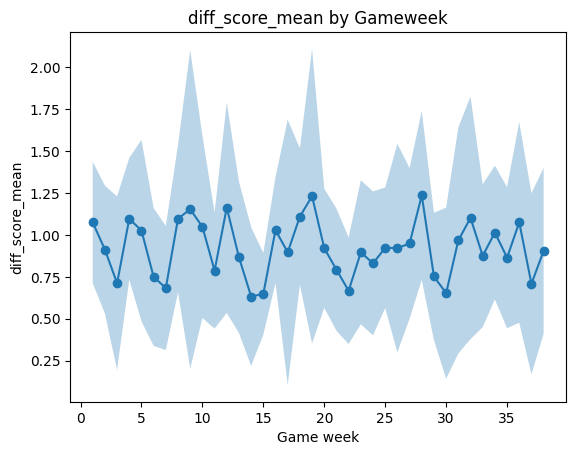

In [9]:
make_scatter_error_plot(one_to_38_week_prediction,'diff_score_mean')
make_scatter_error_plot(one_week_prediction,'diff_score_mean')

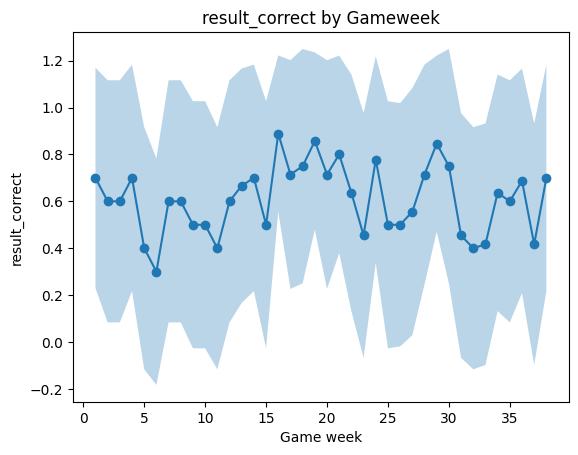

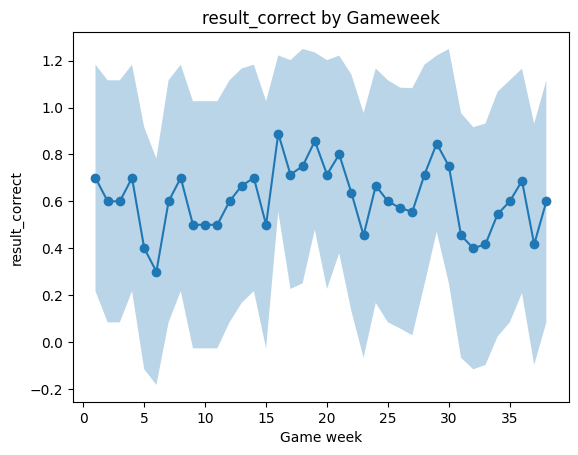

In [13]:
make_scatter_error_plot(one_to_38_week_prediction,'result_correct')
make_scatter_error_plot(one_week_prediction,'result_correct')

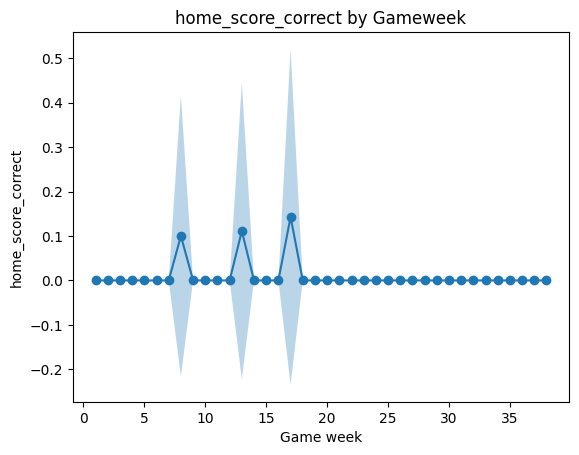

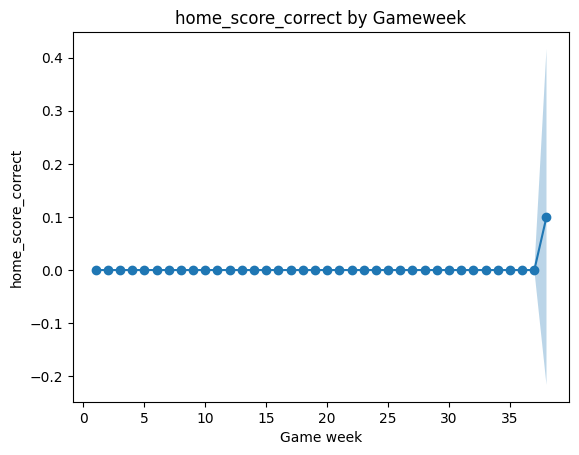

In [16]:
make_scatter_error_plot(one_to_38_week_prediction,'home_score_correct')
make_scatter_error_plot(one_week_prediction,'home_score_correct')


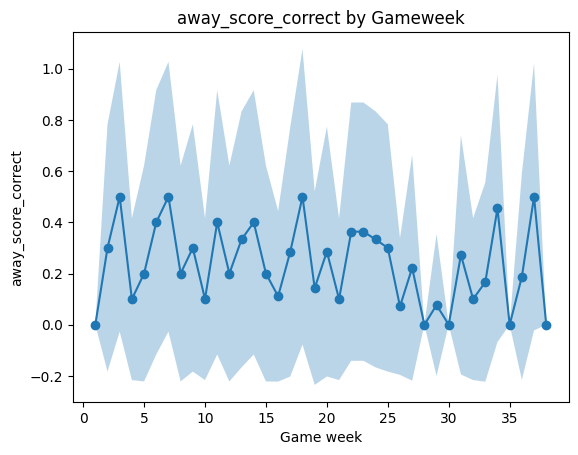

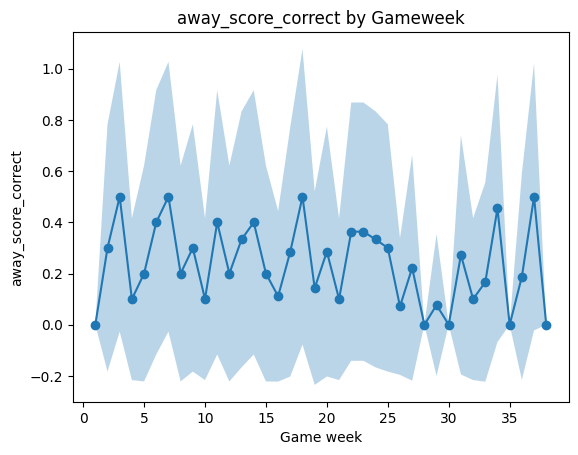

In [14]:
make_scatter_error_plot(one_to_38_week_prediction,'away_score_correct')
make_scatter_error_plot(one_week_prediction,'away_score_correct')
